In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:
  
  print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
C = torch.randn((27, 2))

In [9]:
# Embedding
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [10]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [11]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h

tensor([[-0.3526, -0.7655,  0.9013,  ..., -0.6234,  0.5249, -0.1554],
        [-0.8840, -0.9987,  0.8677,  ..., -0.5155,  0.4623,  0.4708],
        [ 0.9984,  0.9629, -0.0078,  ..., -0.8928,  0.7871,  0.5211],
        ...,
        [ 0.8232, -0.7823,  0.8841,  ..., -0.1347,  0.9520, -0.5730],
        [ 0.0980, -0.8570,  0.9768,  ..., -0.7246,  0.3368, -0.5956],
        [-0.2449, -0.9451,  0.9946,  ..., -0.8241, -0.8612, -0.9305]])

In [12]:
h.shape

torch.Size([32, 100])

In [13]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [14]:
logits = h @ W2 + b2

In [15]:
logits.shape

torch.Size([32, 27])

In [16]:
counts = logits.exp()

In [17]:
prob = counts / counts.sum(1, keepdims=True)

In [18]:
prob.shape

torch.Size([32, 27])

In [19]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(12.9593)

In [20]:
# ------------ now made respectable :) ---------------

In [21]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [22]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 6), generator=g)
W1 = torch.randn((18, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [23]:
sum(p.nelement() for p in parameters) # number of parameters in total

13989

In [24]:
for p in parameters:
  p.requires_grad = True

In [25]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [26]:
lri = []
lossi = []
stepi = []

In [27]:
#  training using X train
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (64,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 18) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

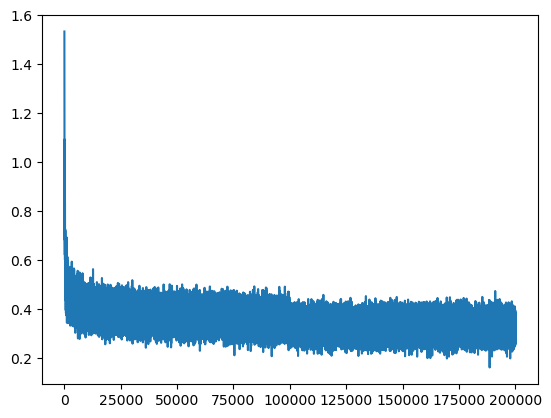

In [28]:
plt.plot(stepi, lossi)

(array([6293.,  898.,  396.,  307.,  206.,  127.,  108.,   94.,   72.,
          64.,   54.,   63.,   49.,   37.,   39.,   26.,   32.,   33.,
          31.,   30.,   24.,   15.,   24.,   26.,   25.,   19.,   25.,
          35.,   31.,   34.,   23.,   29.,   38.,   37.,   47.,   46.,
          39.,   60.,   57.,   87.,   90.,   71.,   96.,   90.,  131.,
         192.,  308.,  440.,  896., 7206.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

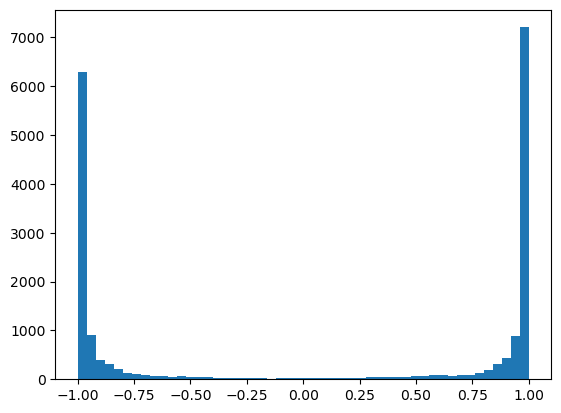

In [34]:
plt.hist(h.view(-1).tolist(), 50)

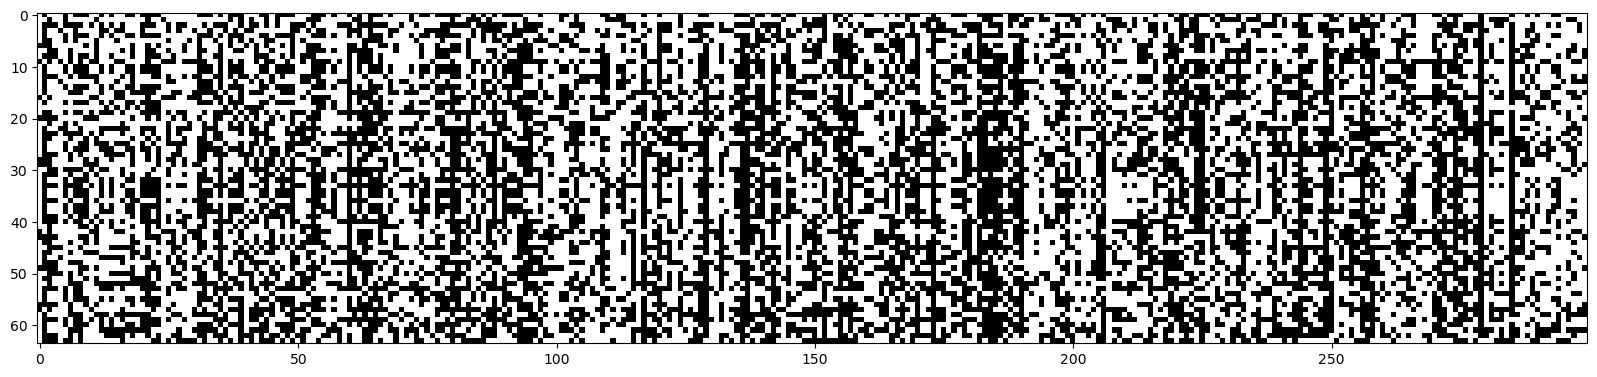

In [36]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation = 'nearest')

In [56]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 18) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1451, grad_fn=<NllLossBackward0>)

In [57]:
# evaluate using X dev set
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 18) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1881, grad_fn=<NllLossBackward0>)

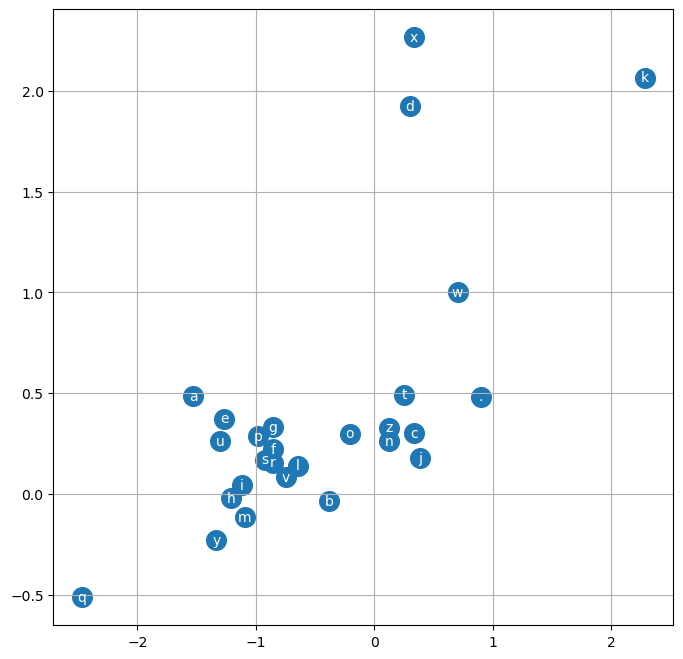

In [58]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [45]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [46]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [47]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mona.
kayah.
see.
mad.
ryla.
rethan.
bre.
leg.
aderedieliah.
milopilvie.
sustanar.
kateloh.
kalin.
shabergelianne.
kin.
renel.
panterorius.
kace.
ryyah.
fael.
